In [1]:
import os
import sys
sys.path.append(os.path.abspath('repo/trans_probs/mvp/'))


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.interpolate import BSpline
from IPython.display import display, Markdown, Latex
import re
import copy

In [3]:
from models import *

In [52]:
# parameters for experiments displayed
# data types
data_types = [1]
# to be changed later
experiments = ['norm2_crossent_comp_val', 'norm2_crossent_bet_val','norm2_crossent_simp_val', 'norm2_exp_comp_val', 'norm2_exp_bet_val', 'norm2_exp_simp_val']
# experiments = ['crossent_simp']
turns = ['b0', 'b1', 'b2']

In [5]:
def get_prep_type(exp_name):
    '''
    Description: uses the experiment name to determine
    where to load data from
    '''
    # grab prep type (the integer contained in the
    # experiment name)
    prep_type = re.findall(r'\d+', exp_name)
    prep_type = prep_type[0]
    prep_type = int(prep_type)

    if int(prep_type) == 1:
        if 'norm' in exp_name:
            prep_type = 'norm1'
        else:
            prep_type = 'mvp1'
    elif int(prep_type) == 2:
        if 'norm' in exp_name:
            prep_type = 'norm2'
        else:
            prep_type = 'mvp2'
    elif int(prep_type) == 3:
        prep_type = 'mvp3'
    elif int(prep_type) == 4:
        prep_type = 'mvp4'
    print('Prep type: %s' % prep_type)
    return prep_type

In [6]:
def get_resp_offr(turn):
    '''
    Description: Determines the name of the response column given the name of the last observed turn
    '''
    turn_num = turn[1]
    turn_type = turn[0]
    if turn != 'start_price_usd':
        turn_num = int(turn_num)
    if turn_type == 'b':
        resp_turn = 's' + str(turn_num)
    elif turn == 'start_price_usd':
        resp_turn = 'b0'
    elif turn_type == 's':
        resp_turn = 'b' + str(turn_num + 1)
    resp_col = 'offr_' + resp_turn
    return resp_col

In [7]:
def get_resp_time(turn):
    '''
    Description: Determines the name of the response column given the 
    name of the last observed turn
    for time models
    '''
    turn_num = turn[1]
    turn_type = turn[0]
    turn_num = int(turn_num)
    if turn_type == 'b':
        resp_turn = 's' + str(turn_num)
    elif turn == 'start_price_usd':
        resp_turn = None
    elif turn_type == 's':
        resp_turn = 'b' + str(turn_num + 1)
    resp_col = 'time_%s' % resp_turn
    return resp_col

In [8]:
def get_prev_offr(turn):
    '''
    Description: get the column name of the previous turn made 
    by the player for whom we're predicting the next
    turn. If the current turn we're predicting is the seller's
    first turn, return 'start_price_usd'. If the current 
    turn we're predicting is the buyer's first turn,  
    '''
    if turn == 'start_price_usd':
        prev_turn = ''
        return prev_turn
    turn_num = int(turn[1])
    turn_type = turn[0]
    if turn_type == 's':
        prev_turn = 'b' + str(turn_num)
    elif turn_type == 'b':
        if turn_num == 0:
            prev_turn = 'start_price_usd'
        else:
            prev_turn = 's' + str(turn_num - 1)
    if 'start_price_usd' not in prev_turn and prev_turn != '':
        prev_turn = 'offr_' + prev_turn
    return prev_turn

In [9]:
def get_model_class(exp_name):
    '''
    Description: Uses experiment name to grab the associated model
    from the models module and aliases it as net
    Input: string giving experiment name
    Output: class of model to be trained
    '''
    if 'cross' in exp_name:
        if 'simp' in exp_name:
            print('Model: Cross Simp')
            net = Cross_simp
        elif 'bet' in exp_name:
            print('Model: Cross between')
            net = Cross_simp
        else:
            net = Cross_comp
            print('Model cross comp')
    else:
        if 'simp' in exp_name:
            print('model exp simp')
            net = Exp_simp
        elif 'bet' in exp_name:
            print('model exp between')
            net = Exp_simp
        else:
            print('model exp comp')
            net = Exp_comp
    return net

In [10]:
def get_num_units(exp_name):
    '''
    Description: gets the number of units in each
    nonlinear activation layer using the experiment name
    '''
    if 'simp' in exp_name:
        num_units = 30
    elif 'bet' in exp_name:
        num_units = 100
    else:
        num_units = 100
    print('Num units: %s' % num_units)
    return num_units

In [11]:
########################################################
# NOT IN USE CURRENTLY
#########################################################
def move_mass(output, ind_prev, ind_curr):
    '''
    output: n x c tensor where n gives number of examples and c gives number of classes
    ind_prev: index of the column for the previous turn
    ind_curr: index of the column for the current turn
    '''
    greater = np.maximum(ind_prev, ind_curr)
    lower = np.minimum(ind_prev, ind_curr)
    sum_greater = torch.sum(output[:, greater:], 1)
    sum_lower = torch.sum(output[:, :(lower + 1)], 1)
    output[:, greater:] = 0
    output[:, :(lower + 1)] = 0
    output[:, lower] = sum_lower
    output[:, greater] = sum_greater
    return output


In [12]:
def get_feat_desc(exp_name):
    '''
    Description: Parses the name of the experiment to extract information about the features used in the model
    '''
    data_type = re.findall(r'\d+', exp_name)[0]
    data_type = int(data_type)
    if 'norm' not in exp_name:
        if data_type % 2 == 0:
            return 'Only offer history and starting price included as features. Training stopped after drawing' + \
            'minibatches (with replacement) equivalent to 20 times the size of the data.'
        else:
            return 'Offer history, buyer feedback scores, fraction of auction remaining at time of offer,' + \
            ' time (in hours) each player took to make hitherto observed offers, number of previous threads ' + \
            'buyer and seller have engaged in, indicators for item category, and quality. Training stopped after' + \
            'drawing minibatches (with replacement) equivalent to 5 times the size of the data'
    else:
        if data_type == 1:
            return 'Offer history normalized by difference between two most recent offers; no date or time features;' + \
            'number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;' + \
            'indicators for item category and quality'
        elif data_type == 2:
            return 'Offer history normalized by difference between two most recent offers; fraction of time remaining,' + \
            'time to make offer for each offer, indicators for whether each offer was made in the morning, evening, night,' + \
            'or afternoon (1 excluded), and the time of day in hours for each observed offer,' + \
            'number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;' + \
            'indicators for item category and quality'
def get_bin_desc(exp_name):
    if 'norm' not in exp_name:
        data_type = int(exp_name[len(exp_name) - 1])
        if data_type <= 2:
            return 'Offer values rounded to every even 50 cent [3, 1000] in symmetric 25 cent window around each ' + \
            'rounding target'
        else:
            return 'Offer values rounded to 1% of most common values observed for offer being predicted provided ' + \
            'that the center of each bin is at least 50 cents from the center of adjacent bins -- this requirement ' + \
            'reduces the number of bins to approximately 170 from about 500'
    else:
        data_type = int(re.findall(r'\d+', exp_name)[0])
        if data_type == 1 or data_type == 2:
            return 'Normalized offer values binned at every hundredth between 0 and 1'
def get_arc_desc(exp_name):
    if 'cross' in exp_name:
        return 'Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained ' + \
        'using cross entropy loss, predicts the center of the bin with the highest score'
    else:
        return 'Hidden softmax layer after final non-linear activation layer constructs a distribution over bins ' + \
        'then output layer predicts the expectation of this distribution. Trained using squared loss.'
def get_comp_desc(exp_name):
    if 'simp' in exp_name:
        return '1 non-linear activation layer containing 30 units'
    else:
        return '2 non-linear activation layers containing 100 units'

In [13]:
def check_done(exp_name, turn):
    '''
    Description: Checks whether an experiment is complete
    '''
    return os.path.isfile('models/exps/%s/model_%s.pth.tar' % (exp_name, turn))

In [14]:
def pandas_df_to_markdown_table(df):
    '''
    Description: converts pandas data frame to markdown table
    '''
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

In [47]:
def get_exp_data(exp_name, turn, offr_mod):
    '''
    Description: Loads all necessary test data and model specification files (bins, loss history, 
    feature dictionary, class series) and computes model predictions...Stores all data and predictions used later
    in an output dictionary
    '''
    if not offr_mod and turn == 'start_price_usd':
        raise ValueError('No time response to the listing')
        
    # prep type
    prep_type = get_prep_type(exp_name)
    # loss history
    with open('models/exps/%s/loss_%s.pickle' % (exp_name, turn), 'rb') as f:
        loss_dict = pickle.load(f)
        # get training loss history
        loss = loss_dict['train_loss']

        # if a validation set was used, grab the validation set loss too
        if 'val' in exp_name:
            valid_loss = loss_dict['valid_loss']
    
    f.close()
    if len(loss) > 0:
        if not isinstance(loss[0], torch.FloatTensor):
            loss = loss[1:]
    # class series
    class_series = pd.read_csv('models/exps/%s/class_series_%s.csv' % (exp_name, turn), squeeze=True, index_col=0, header=None)
    classes = class_series.index.values
    
    # feature dictionary
    with open('models/exps/%s/featdict_%s.pickle' % (exp_name, turn), 'rb') as f:
        feat_dict = pickle.load(f)
    f.close()
    reverse = {}
    for col, ind in feat_dict.items():
        reverse[ind] = col
    
    # column list...no idea why I used a dictionary for this tbh
    col_list = []
    for i in range(len(reverse)):
        next_col = reverse[i]
        col_list.append(next_col)

    # normalization attributes
    norm_df = pd.read_csv('data/exps/%s/%s/norm.csv' % (prep_type, turn))
    
    # load bins and midpoints
    if offr_mod:
        with open('data/exps/%s/%s/bins.pickle' % (prep_type, turn), 'rb') as f:
            bin_dict = pickle.load(f)
        f.close()
        midpoints = bin_dict['midpoints']
        bins = bin_dict['bins']
    else:
        with open('data/exps/%s/%s/time_bins.pickle' % (prep_type, turn), 'rb') as f:
            bin_dict = pickle.load(f)
        f.close()
        midpoints = bin_dict['time_midpoints']
        bins = bin_dict['time_bins']
    
    # load model parameters
    model_dict = torch.load('models/exps/%s/model_%s.pth.tar' % (exp_name, turn))
    
    # normalized test data for use in model
    # load test data
    test_df = pd.read_csv('data/exps/%s/normed/test_concat_%s.csv' % (prep_type, turn))
    #############
    # TEMPORARY FIX WHILE THIS PROBLEM REMAINS WITH THIS SUBSET OF DATA
    ##############
    if 'norm1' in exp_name:
        binned_df = pd.read_csv('data/exps/%s/binned/test_concat_%s.csv' % (prep_type, turn))
        test_df = test_df.loc[binned_df[binned_df['start_price_usd'] < 1000].index]
    
    if offr_mod:
        # prep oracle and baseline for offer model
        if turn != 'start_price_usd':
            # grabbing most recent offer from the player for whom we're predicting the next offer (ref_old)
            # and the most recent offer from the opposing player (ref_rec)
            first_off = test_df['ref_old']
            sec_off = test_df['ref_rec']

            low_off = np.minimum(first_off.values, sec_off.values)
            high_off = np.maximum(first_off.values, sec_off.values)

            # initializing oracle and computing rough midpoint baseline
            base_pred = (first_off + sec_off) / 2
            oracle = base_pred.copy()
            base_pred = base_pred.values
            base_pred = torch.from_numpy(base_pred).float()
        # create baseline for model where we're predicting b0
        else:
            # extract recent reference 
            sec_off = test_df['ref_rec']
            base_pred = sec_off / 2
            oracle = base_pred.values
            base_pred = torch.from_numpy(base_pred).float()
    else:
        # prep baseline for time model
        # baseline predicts all offer response take 24 hours
        # oracle makes the same prediction except it predicts 0 when 
        # the offer is automatically rejected/accepted 
        # and 48 * 60 when the offer expires
        base_pred = np.ones(len(test_df.index))
        base_pred = base_pred * 24 * 60
        base_pred = pd.Series(base_pred, index=test_df.index)
        # establishing oracle
        oracle = base_pred.copy()
        # convert base pred back to simple numpy
        base_pred = base_pred.values
        base_pred = torch.from_numpy(base_pred).float()
        
        
    # get model class using experiment name
    net = get_model_class(exp_name)

    # grab the number of units in an activation layer and other model features
    num_units = get_num_units(exp_name)
    num_features = len(col_list)
    num_classes = len(classes)

    # load parameters into net
    if 'cross' in exp_name:
        model = net(num_features, num_units, num_classes)
    else:
        classes = torch.from_numpy(classes).float()
        model = net(num_features, num_units, num_classes, classes)

    # load model weights
    model.load_state_dict(model_dict)

    # get target for model
    if offr_mod:
        targ = test_df[get_resp_offr(turn)].values
        # get true value of target
        true_targ = test_df['ref_resp'].values
    else:
        true_targ = test_df[get_resp_time(turn)].values
    
    if offr_mod:
        if turn != 'start_price_usd':
            # creating oracle baseline -- guesses 50% if not rejected / accepted, otherwise
            # matches behavior
            # find rejects 
            rejects = oracle[true_targ == first_off].index
            # find accepted offers
            accepts = oracle[true_targ == sec_off].index

            # reset oracle values to match accept offers
            oracle.loc[accepts] = sec_off.loc[accepts].values

            # reset oracle values to match declined offers
            oracle.loc[rejects] = first_off.loc[rejects].values
        else:
            # get turns where the buyer just paid the starting price
            full_price = oracle[true_targ == sec_off].index

            # for the oracle, set the predicted response to be equal to the true response in these instances
            oracle.loc[full_price] = sec_off.loc[full_price]
    else:
        # create oracle -- guesses 24 hours if not automatically accepted/rejected or allowed
        # to time out, otherwise matches this behavior
        # find auto response offers
        auto_ids = oracle[true_targ == 0].index
        # find time out response offers
        timeout_ids = oracle[true_targ == 48*60].index
        # reset oracle values to match auto responses
        oracle.loc[auto_ids] = 0
        # reset oracle values to match timeout responses
        oracle.loc[timeout_ids] = 48 * 60

    # convert format to torch
    true_targ = torch.from_numpy(true_targ).float()
    oracle_pred = torch.from_numpy(oracle.values).float()

    # drop response column and reference columns from test df
    extra_cols = ['ref_old', 'ref_rec', 'ref_resp', get_resp_offr(turn), get_resp_time(turn)]
    for col in extra_cols:
        if col in test_df.columns:
            test_df.drop(columns=col, inplace=True)

    # rearrange columns to match model input from training
    test_df = test_df[col_list]
    test_ten = torch.from_numpy(test_df.values).float()
    mod_pred = model(test_ten)
    
    if offr_mod:
        sec_off = torch.from_numpy(sec_off.values).float()
        if turn != 'start_price_usd':
            # interpolate the model prediction to convert to dollars
            # from normalized value
            first_off = torch.from_numpy(first_off.values).float()
            if 'cross' not in exp_name:
                # print(mod_pred.size())
                # print(sec_off.size())
                # print(first_off.size())
                mod_pred = mod_pred.view(-1)
                mod_pred = mod_pred * sec_off + (1-mod_pred) * first_off

        else:
            # interpolate model prediction from starting price
            if 'cross' not in exp_name:
                mod_pred = mod_pred * sec_off
                
        # DEPRECATED MOVED MASS PREDICTION 
        ##############################################################################
        # create moved mass prediction by predicting the lower of the two previous
        # offers when our prediction is less than that low
        # and predicting the higher of the two previous offers when our prediction
        # is greater than that offer 
        
        # numpy_mod_pred = mod_pred.detach().numpy()
        # mm_pred = numpy_mod_pred
        # find indices are out of bounds low
        # oobl = low_off > numpy_mod_pred
        # find indices which are out of bounds high
        # oobh = high_off < numpy_mod_pred
        # reset high indices to be equal to high previous turn
        # mm_pred[oobh] = high_off[oobh]
        # reset low indices to be equal to low from previous turns
        # mm_pred[oobl] = low_off[oobl]
        
        # change format
        # mm_pred = torch.from_numpy(mm_pred).float()
        
        # create moved mass prediction by predicting the start_price when our prediction is greater 
        # than the start price
        # numpy_mod_pred = mod_pred.detach().numpy()
        # mm_pred = numpy_mod_pred
        # find indices where the model prediction is greater than the start price
        # start_off_numpy = sec_off.numpy()
        # oobh = numpy_mod_pred > start_off_numpy
        # mm_pred[oobh] = start_off_numpy[oobh]
        # mm_pred = torch.from_numpy(mm_pred).float()
        ##################################################################

    del test_df
    del test_ten
    
    data_dict = {}
    data_dict['loss'] = loss
    data_dict['class_series'] = class_series
    data_dict['mod_pred'] = mod_pred
    data_dict['oracle_pred'] = oracle_pred
    
    # TEMP MOVE MASS
    ########################################
    # data_dict['mm_pred'] = mm_pred
    ########################################
    
    data_dict['base_pred'] = base_pred
    data_dict['targ'] = true_targ
    # for reconstructing true predictionf from
    # diff-norm prediction
    if offr_mod:
        data_dict['sec_off'] = sec_off
        if turn != 'start_price_usd':
            data_dict['first_off'] = first_off
            
    if 'val' in exp_name:
        data_dict['valid_loss'] = valid_loss

    return data_dict

In [48]:
def show_loss_plots(loss, valid):
    if not valid:
        display(Markdown('##### Raw Training Loss Curve'))
    else:
        display(Markdown('##### Raw Validation Set Loss Curve'))
        
    x = np.array(list(range(len(loss))))
    loss = [float(curr_loss) for curr_loss in loss]
    loss = np.array(loss)
    plt.plot(x, loss)
    plt.show()
    
    if not valid:
        display(Markdown('##### Smoothed Training Loss Curve'))
    else:
        display(Markdown('##### Smoothed Validation Set Loss Curve'))
        
    xnew = np.linspace(x.min(), x.max(), 150)
    avg = []
    prev = 0
    for currx in xnew:
        portion = loss[int(prev):(int(currx) + 1)]
        avg.append(portion.mean())
        prev = int(currx)
    avg = np.array(avg)
    # final error is around 3k
    plt.plot(xnew, avg)
    plt.show()
    
    if not valid:
        display(Markdown('##### Smoothed and Zoomed Training Loss Curve'))
    else:
        display(Markdown('##### Smoothed and Zoomed Validation Set Loss Curve'))
    xnew = np.linspace(x.min(), x.max(), 150)
    avg = []
    prev = 0
    for currx in xnew:
        portion = loss[int(prev):(int(currx) + 1)]
        avg.append(portion.mean())
        prev = int(currx)
    avg = np.array(avg)
    xnew = xnew[20:]
    avg = avg[20:]
    # final error is around 3k
    plt.plot(xnew, avg)
    plt.show()
    

In [49]:
def get_class_pred(mod_pred, class_series):
    '''
    Grab class associated with class index from cross entropy model or expecation model with last layer 
    stripped, for use in squared loss calculation rather than cross ent
    '''
    _, class_ind = mod_pred.max(1)
    mod_pred = class_series.loc[class_ind.numpy().astype(np.int64)].values
    na_flag = np.any(np.isnan(mod_pred))
    if na_flag:
        raise ValueError('Discovered NA prediction in crossentropy model')
    mod_pred = torch.from_numpy(mod_pred).float()
    
    return mod_pred

In [50]:
def main():
    all_resp_turns = [get_resp_offr(turn) for turn in turns]
    summary_test_df = pd.DataFrame(0.0, index=all_resp_turns, columns=['oracle', 'baseline'])
    for exp in experiments:
        for data_type in data_types:
            exp_name = exp
            offr_mod = 'time' not in exp_name
            results_series = pd.Series(np.NaN, index=all_resp_turns)
            if 'cross' in exp_name:
                print('Add moved mass function after debugging bin script')
                # mm_results_series = pd.Series(np.NaN, index=all_resp_turns)
            if not os.path.isfile('models/exps/%s/tbd.txt' % exp_name):
                # experiment header
                display(Markdown('## Experiment Summary: %s' % exp_name))
                display(Markdown('### Characteristics'))
                display(Markdown('* Bins: %s' % get_bin_desc(exp_name)))
                display(Markdown('* Complexity: %s' % get_comp_desc(exp_name)))
                display(Markdown('* Architecture: %s' % get_arc_desc(exp_name)))
                display(Markdown('* Features: %s' % get_feat_desc(exp_name)))
                for turn in turns:
                    if check_done(exp_name, turn):
                        data_dict = get_exp_data(exp_name, turn, offr_mod)
                        display(Markdown('### Analysis of Model for %s' % get_resp_offr(turn)))
                        display(Markdown('#### Training Curves'))
                        if len(data_dict['loss']) > 0:
                            show_loss_plots(data_dict['loss'], False)
                        else:
                            display(Markdown('##### Problem with Loss Object'))
                        if 'val' in exp_name:
                            display(Markdown('#### Validation Loss Curve'))
                            show_loss_plots(data_dict['valid_loss'], True)
                            
                        display(Markdown('#### Test Error'))
                        mod_pred = data_dict['mod_pred']
                        base_pred = data_dict['base_pred']
                        oracle_pred = data_dict['oracle_pred']
                        
                        class_series = data_dict['class_series']
                        targ = data_dict['targ']
                        
                        if offr_mod:
                            sec_off = data_dict['sec_off']
                            if turn != 'start_price_usd':
                                first_off = data_dict['first_off']
                        # series where index gives dllar value of class, and value gives location in class index array
                        class_locs = class_series.copy()
                        # series where index gives location in class index array and value gives dollar value of class
                        class_series = pd.Series(class_series.index.values)
                        
                        criterion = nn.MSELoss(size_average=True, reduce=True)
                        loss = criterion
                        
                        if 'cross' in exp_name:
                            # TEMP FIX WHEN MOVED MASS IMPLEMENTED
                            #################################################
                            # find the index of the max value in each row
                            # prev_ind = class_locs.loc[prev_turn]
                            # curr_ind =  class_locs.loc[curr_turn]
                            # print(class_locs)
                            # print(class_locs.loc[663.5])
                            # print(prev_turn[prev_ind[prev_ind.isna()].index])
                            # print(curr_turn[curr_ind[curr_ind.isna()].index])
                            # moved_mass_pred = move_mass(mod_pred, prev_ind.values, curr_ind.values)
                            # moved_mass_pred = get_class_pred(moved_mass_pred, class_series)
                            # moved_mass_pred = moved_mass_pred.view(-1)
                            # moved_mass_loss = criterion(moved_mass_pred, targ)
                            # mm_results_series.loc[get_resp_offr(turn)] = moved_mass_loss.detach().numpy()
                            ############################################################
                            mod_pred = get_class_pred(mod_pred, class_series)
                            # print('norm offer pred')
                            #  print(mod_pred)
                            # interpolate predicted value of offer from nomralized difference prediction
                            if offr_mod:
                                if turn != 'start_price_usd':
                                    mod_pred = mod_pred * sec_off + (1-mod_pred) * first_off
                                else:
                                    mod_pred = mod_pred * sec_off
                                
                        mod_pred = mod_pred.view(-1)
                        base_pred = base_pred.view(-1)
                        oracle_pred = oracle_pred.view(-1)
                        targ = targ.view(-1)
                        
                        base_loss = criterion(base_pred, targ)
                        oracle_loss = criterion(oracle_pred, targ)
                        mod_loss = criterion(mod_pred, targ)
                        results_series.loc[get_resp_offr(turn)] = mod_loss.detach().numpy()
                        
                        base_col = 'baseline'
                        oracle_col = 'oracle'
                        
                        curr_base_val = summary_test_df.at[get_resp_offr(turn), base_col]
                        if curr_base_val == 0:
                            summary_test_df.at[get_resp_offr(turn), base_col] = base_loss
                        
                        curr_oracle_val = summary_test_df.at[get_resp_offr(turn), oracle_col]
                        if curr_base_val == 0:
                            summary_test_df.at[get_resp_offr(turn), oracle_col] = oracle_loss
                        
                        display(Markdown('* Baseline Loss: %.2f' % base_loss))
                        display(Markdown('* Oracle Loss: %.2f' % oracle_loss))
                        display(Markdown('* Model Loss: %.2f' % mod_loss))
                    else:
                        display(Markdown('### Model for %s incomplete' % get_resp_offr(turn)))
            summary_test_df[exp_name] = results_series
            # TEMP -- FIX WHEN MOVED MASS IMPLEMENTED
            ##########################################################################
            # if 'cross' in exp_name:
                # summary_test_df['mm_' + exp_name] = mm_results_series
            ############################################################################
    summary_test_df = summary_test_df.transpose()
    model_series = pd.Series(summary_test_df.index.values, summary_test_df.index)
    summary_test_df.insert(0, 'model', model_series)
    pandas_df_to_markdown_table(summary_test_df)

Add moved mass function after debugging bin script


## Experiment Summary: norm2_crossent_comp_val

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history normalized by difference between two most recent offers; fraction of time remaining,time to make offer for each offer, indicators for whether each offer was made in the morning, evening, night,or afternoon (1 excluded), and the time of day in hours for each observed offer,number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm2
Model cross comp
Num units: 100


### Analysis of Model for offr_s0

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

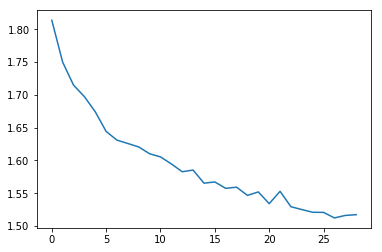

##### Smoothed Validation Set Loss Curve

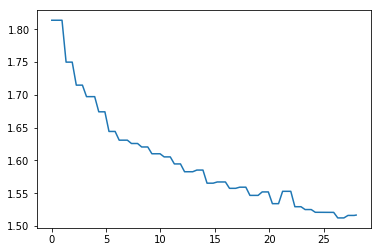

##### Smoothed and Zoomed Validation Set Loss Curve

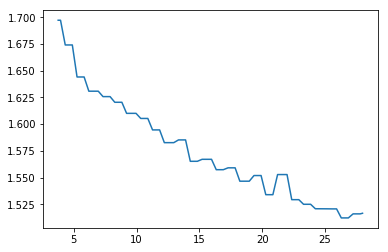

#### Test Error

* Baseline Loss: 1808.21

* Oracle Loss: 170.75

* Model Loss: 679.32

Prep type: norm2
Model cross comp
Num units: 100


### Analysis of Model for offr_s1

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

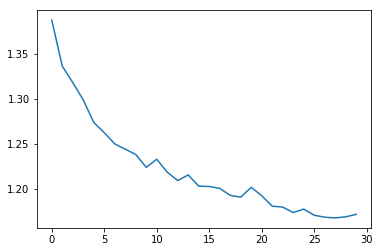

##### Smoothed Validation Set Loss Curve

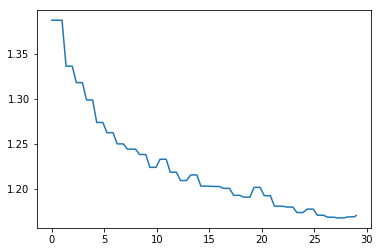

##### Smoothed and Zoomed Validation Set Loss Curve

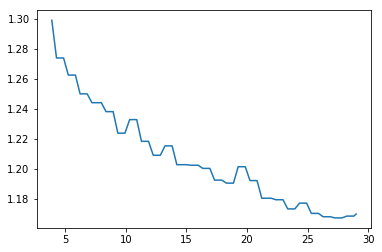

#### Test Error

* Baseline Loss: 1605.91

* Oracle Loss: 76.83

* Model Loss: 350.20

Prep type: norm2
Model cross comp
Num units: 100


### Analysis of Model for offr_s2

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

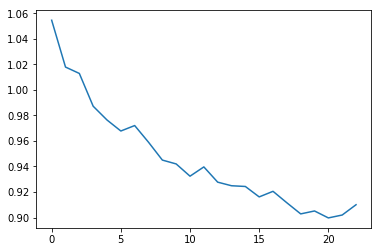

##### Smoothed Validation Set Loss Curve

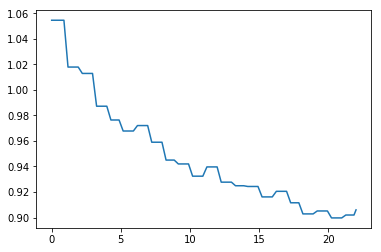

##### Smoothed and Zoomed Validation Set Loss Curve

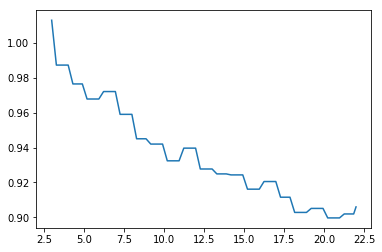

#### Test Error

* Baseline Loss: 1444.54

* Oracle Loss: 42.61

* Model Loss: 250.76

Add moved mass function after debugging bin script


## Experiment Summary: norm2_crossent_bet_val

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history normalized by difference between two most recent offers; fraction of time remaining,time to make offer for each offer, indicators for whether each offer was made in the morning, evening, night,or afternoon (1 excluded), and the time of day in hours for each observed offer,number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm2
Model: Cross between
Num units: 100


### Analysis of Model for offr_s0

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

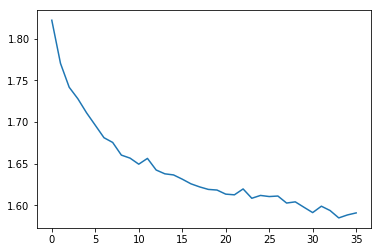

##### Smoothed Validation Set Loss Curve

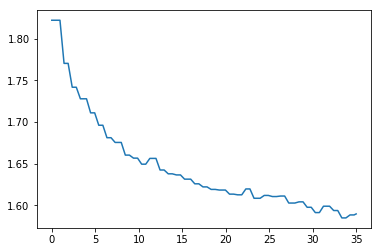

##### Smoothed and Zoomed Validation Set Loss Curve

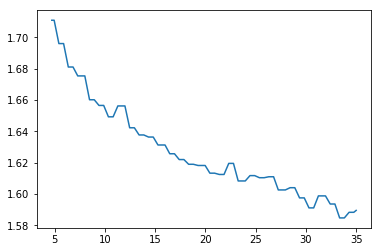

#### Test Error

* Baseline Loss: 1808.21

* Oracle Loss: 170.75

* Model Loss: 655.76

Prep type: norm2
Model: Cross between
Num units: 100


### Analysis of Model for offr_s1

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

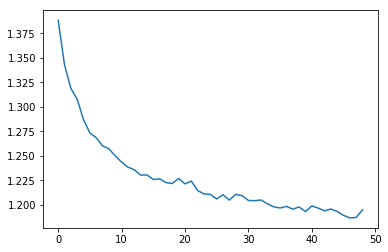

##### Smoothed Validation Set Loss Curve

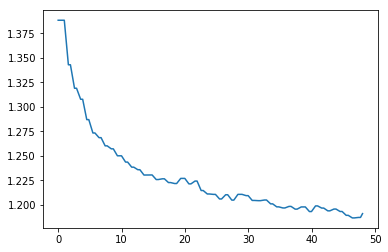

##### Smoothed and Zoomed Validation Set Loss Curve

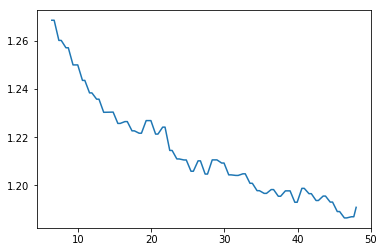

#### Test Error

* Baseline Loss: 1605.91

* Oracle Loss: 76.83

* Model Loss: 339.60

Prep type: norm2
Model: Cross between
Num units: 100


### Analysis of Model for offr_s2

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

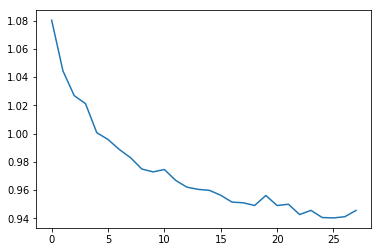

##### Smoothed Validation Set Loss Curve

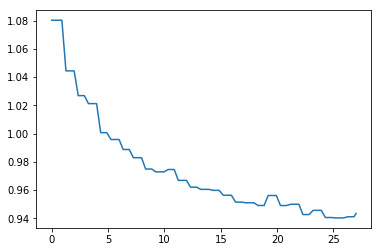

##### Smoothed and Zoomed Validation Set Loss Curve

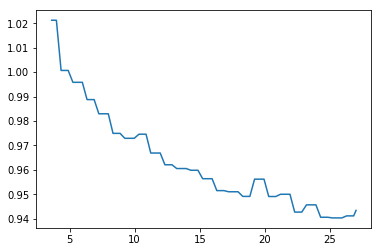

#### Test Error

* Baseline Loss: 1444.54

* Oracle Loss: 42.61

* Model Loss: 307.08

Add moved mass function after debugging bin script


## Experiment Summary: norm2_crossent_simp_val

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Standard multi-class prediction arcitecture, outputting scores over all possible bins, trained using cross entropy loss, predicts the center of the bin with the highest score

* Features: Offer history normalized by difference between two most recent offers; fraction of time remaining,time to make offer for each offer, indicators for whether each offer was made in the morning, evening, night,or afternoon (1 excluded), and the time of day in hours for each observed offer,number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm2
Model: Cross Simp
Num units: 30


### Analysis of Model for offr_s0

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

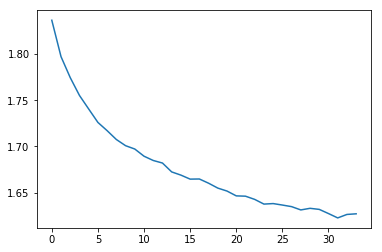

##### Smoothed Validation Set Loss Curve

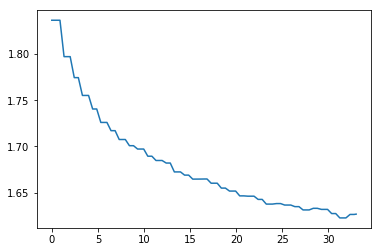

##### Smoothed and Zoomed Validation Set Loss Curve

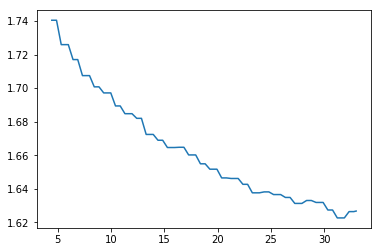

#### Test Error

* Baseline Loss: 1808.21

* Oracle Loss: 170.75

* Model Loss: 681.01

Prep type: norm2
Model: Cross Simp
Num units: 30


### Analysis of Model for offr_s1

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

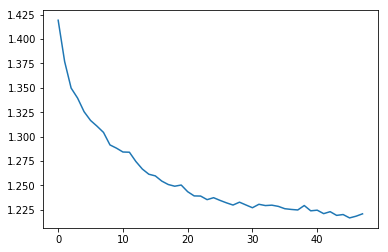

##### Smoothed Validation Set Loss Curve

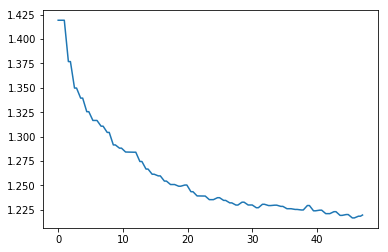

##### Smoothed and Zoomed Validation Set Loss Curve

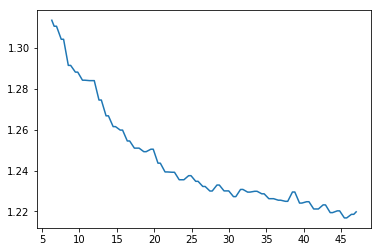

#### Test Error

* Baseline Loss: 1605.91

* Oracle Loss: 76.83

* Model Loss: 365.74

Prep type: norm2
Model: Cross Simp
Num units: 30


### Analysis of Model for offr_s2

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

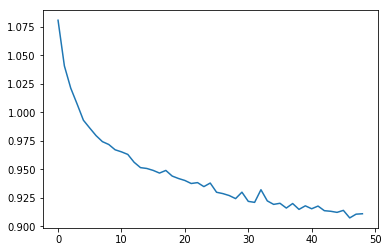

##### Smoothed Validation Set Loss Curve

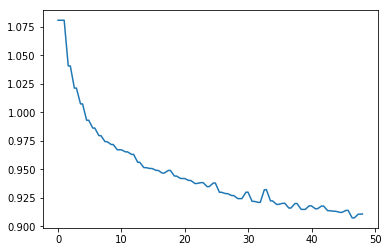

##### Smoothed and Zoomed Validation Set Loss Curve

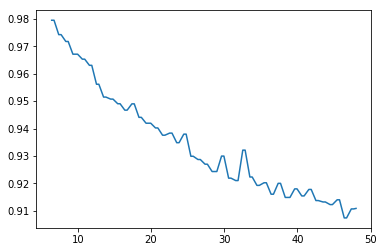

#### Test Error

* Baseline Loss: 1444.54

* Oracle Loss: 42.61

* Model Loss: 299.76

## Experiment Summary: norm2_exp_comp_val

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history normalized by difference between two most recent offers; fraction of time remaining,time to make offer for each offer, indicators for whether each offer was made in the morning, evening, night,or afternoon (1 excluded), and the time of day in hours for each observed offer,number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm2
model exp comp
Num units: 100


### Analysis of Model for offr_s0

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

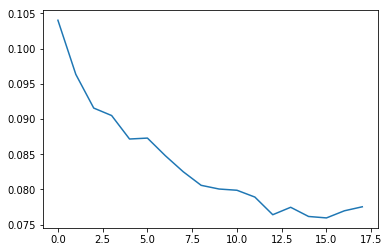

##### Smoothed Validation Set Loss Curve

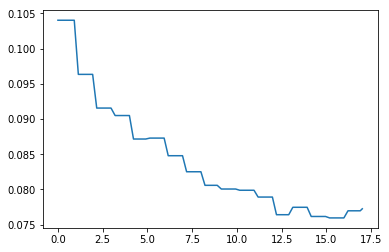

##### Smoothed and Zoomed Validation Set Loss Curve

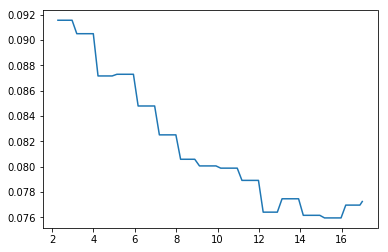

#### Test Error

* Baseline Loss: 1808.21

* Oracle Loss: 170.75

* Model Loss: 404.91

Prep type: norm2
model exp comp
Num units: 100


### Analysis of Model for offr_s1

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

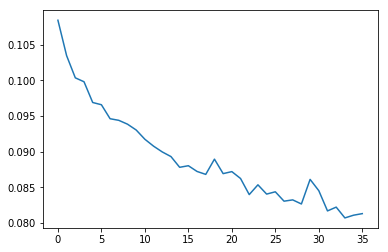

##### Smoothed Validation Set Loss Curve

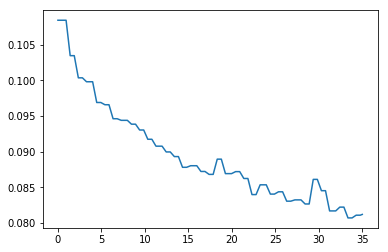

##### Smoothed and Zoomed Validation Set Loss Curve

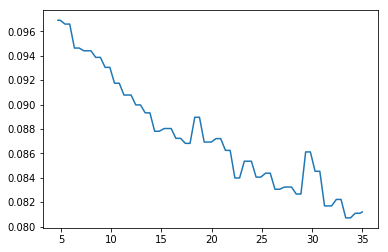

#### Test Error

* Baseline Loss: 1605.91

* Oracle Loss: 76.83

* Model Loss: 217.03

Prep type: norm2
model exp comp
Num units: 100


### Analysis of Model for offr_s2

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

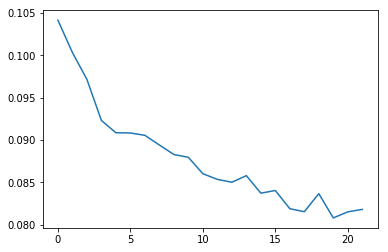

##### Smoothed Validation Set Loss Curve

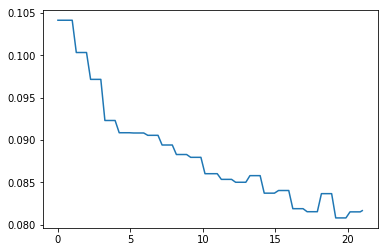

##### Smoothed and Zoomed Validation Set Loss Curve

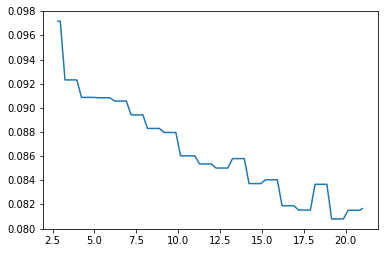

#### Test Error

* Baseline Loss: 1444.54

* Oracle Loss: 42.61

* Model Loss: 190.40

## Experiment Summary: norm2_exp_bet_val

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 2 non-linear activation layers containing 100 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history normalized by difference between two most recent offers; fraction of time remaining,time to make offer for each offer, indicators for whether each offer was made in the morning, evening, night,or afternoon (1 excluded), and the time of day in hours for each observed offer,number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm2
model exp between
Num units: 100


### Analysis of Model for offr_s0

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

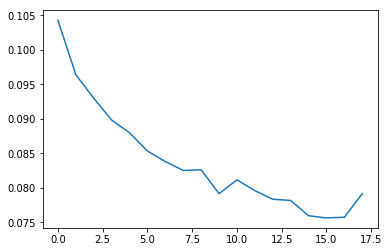

##### Smoothed Validation Set Loss Curve

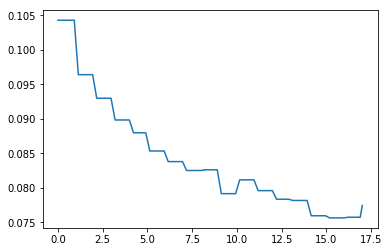

##### Smoothed and Zoomed Validation Set Loss Curve

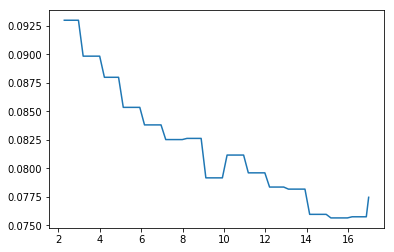

#### Test Error

* Baseline Loss: 1808.21

* Oracle Loss: 170.75

* Model Loss: 402.56

Prep type: norm2
model exp between
Num units: 100


### Analysis of Model for offr_s1

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

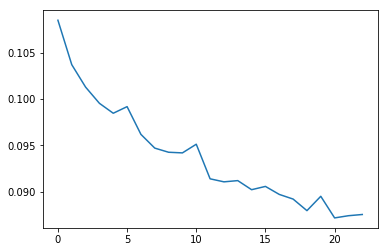

##### Smoothed Validation Set Loss Curve

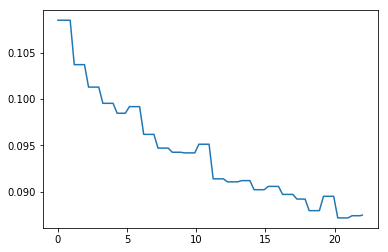

##### Smoothed and Zoomed Validation Set Loss Curve

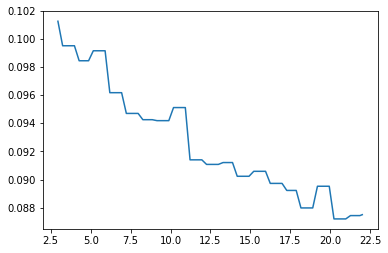

#### Test Error

* Baseline Loss: 1605.91

* Oracle Loss: 76.83

* Model Loss: 243.37

Prep type: norm2
model exp between
Num units: 100


### Analysis of Model for offr_s2

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

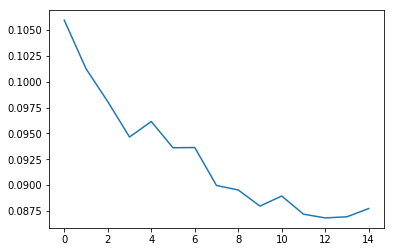

##### Smoothed Validation Set Loss Curve

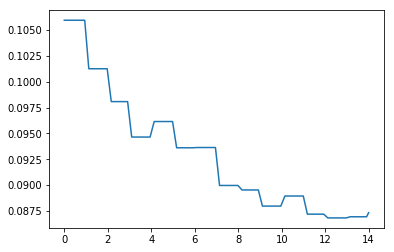

##### Smoothed and Zoomed Validation Set Loss Curve

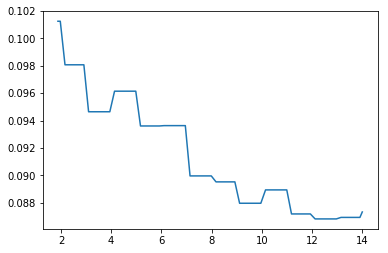

#### Test Error

* Baseline Loss: 1444.54

* Oracle Loss: 42.61

* Model Loss: 235.14

## Experiment Summary: norm2_exp_simp_val

### Characteristics

* Bins: Normalized offer values binned at every hundredth between 0 and 1

* Complexity: 1 non-linear activation layer containing 30 units

* Architecture: Hidden softmax layer after final non-linear activation layer constructs a distribution over bins then output layer predicts the expectation of this distribution. Trained using squared loss.

* Features: Offer history normalized by difference between two most recent offers; fraction of time remaining,time to make offer for each offer, indicators for whether each offer was made in the morning, evening, night,or afternoon (1 excluded), and the time of day in hours for each observed offer,number of previous threads and other experience features, rounding and slack features for 1, 5, 10, 25;indicators for item category and quality

Prep type: norm2
model exp simp
Num units: 30


### Analysis of Model for offr_s0

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

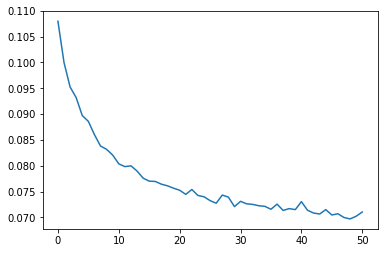

##### Smoothed Validation Set Loss Curve

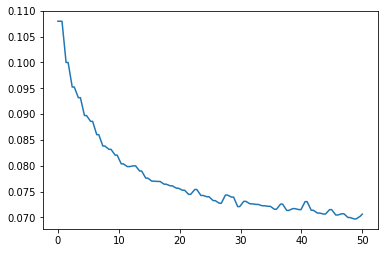

##### Smoothed and Zoomed Validation Set Loss Curve

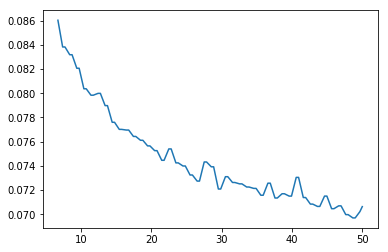

#### Test Error

* Baseline Loss: 1808.21

* Oracle Loss: 170.75

* Model Loss: 426.69

Prep type: norm2
model exp simp
Num units: 30


### Analysis of Model for offr_s1

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

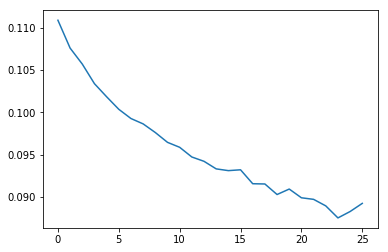

##### Smoothed Validation Set Loss Curve

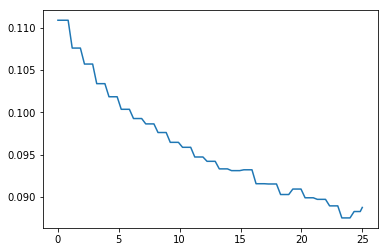

##### Smoothed and Zoomed Validation Set Loss Curve

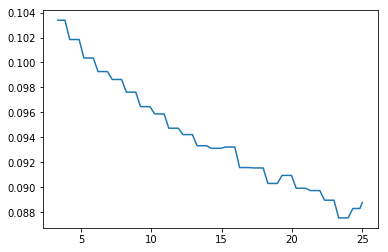

#### Test Error

* Baseline Loss: 1605.91

* Oracle Loss: 76.83

* Model Loss: 242.10

Prep type: norm2
model exp simp
Num units: 30


### Analysis of Model for offr_s2

#### Training Curves

##### Problem with Loss Object

#### Validation Loss Curve

##### Raw Validation Set Loss Curve

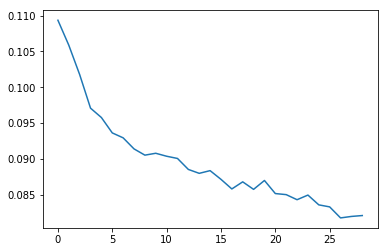

##### Smoothed Validation Set Loss Curve

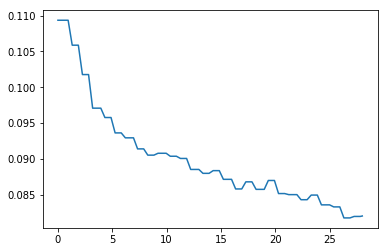

##### Smoothed and Zoomed Validation Set Loss Curve

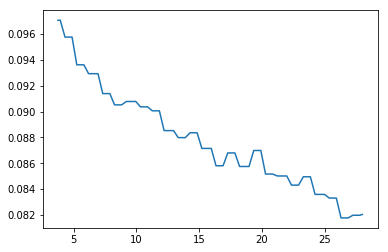

#### Test Error

* Baseline Loss: 1444.54

* Oracle Loss: 42.61

* Model Loss: 200.51

model|offr_s0|offr_s1|offr_s2
---|---|---|---
oracle|170.75027465820312|76.83033752441406|42.606651306152344
baseline|1808.2117919921875|1605.911865234375|1444.5416259765625
norm2_crossent_comp_val|679.3207397460938|350.2001647949219|250.76197814941406
norm2_crossent_bet_val|655.75732421875|339.60247802734375|307.0777587890625
norm2_crossent_simp_val|681.0051879882812|365.7404479980469|299.7566223144531
norm2_exp_comp_val|404.90533447265625|217.0261993408203|190.4009246826172
norm2_exp_bet_val|402.5577697753906|243.37245178222656|235.1417694091797
norm2_exp_simp_val|426.68701171875|242.10223388671875|200.50906372070312


In [53]:
main()